### Extract core financial concept for data model construction 

#### 1.1 Extract all qa-pairs

In [2]:
import pandas as pd
# Load the dataset
file_path = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json" 

# Load JSONL file (each line is a JSON object)
df = pd.read_json(file_path, lines=True)

# Preview the dataset
print("Columns in dataset:", df.columns)
df.head()

Columns in dataset: Index(['ID', 'question', 'answer', 'context', 'gold_context', 'operation',
       'source'],
      dtype='object')


,ID,question,answer,context,gold_context,operation,source
0,ADI/2009/page_49.pdf,what is the the interest expense in 2009?,380,['interest rate to a variable interest rate ba...,{'text_1': 'if libor changes by 100 basis poin...,"divide(100, 100), divide(3.8, #0)",FinQA
1,AAL/2018/page_13.pdf,what was the total operating expenses in 2018 ...,41932,['the following table shows annual aircraft fu...,{'table_1': 'year the 2018 of gallons is 4447 ...,"divide(9896, 23.6%)",FinQA
2,INTC/2013/page_71.pdf,what percentage of total cash and investments ...,53%,['the fair value of our grants receivable is d...,{'table_1': '( in millions ) the available-for...,"divide(14001, 26302)",FinQA
3,ETR/2008/page_313.pdf,what is the growth rate in net revenue in 2008?,-3.2%,"[""entergy louisiana , llc management's financi...",{'table_1': 'the 2007 net revenue of amount ( ...,"subtract(959.2, 991.1), divide(#0, 991.1)",FinQA
4,C/2010/page_272.pdf,what was the growth rate of the loans held-for...,56.25%,"['the significant changes from december 31 , 2...",{'table_1': 'in billions of dollars the decemb...,"divide(2.5, 1.6), divide(#0, 1.6)",FinQA


In [3]:
# Filter for question-answer pairs
qa_df = df[['question', 'answer']].copy()
qa_df.dropna(subset=['question', 'answer'], inplace=True)

# Preview the data
print(f"Loaded {len(qa_df)} QA pairs")
qa_df.head()

Loaded 17201 QA pairs


,question,answer
0,what is the the interest expense in 2009?,380
1,what was the total operating expenses in 2018 ...,41932
2,what percentage of total cash and investments ...,53%
3,what is the growth rate in net revenue in 2008?,-3.2%
4,what was the growth rate of the loans held-for...,56.25%


#### 1.2. Create a list with all relevant entities and relationships

Create a whitelist for relevant metrics: 

In [22]:
import re, requests, pandas as pd
from lxml import etree

# -----------------------------------------------------------------
# ❶  Choose ONE input:  URL  or  local file you downloaded
# -----------------------------------------------------------------
XSD_SOURCE = "file"           # "url"  or  "file"

if XSD_SOURCE == "url":
    xml_bytes = requests.get(
        "https://xbrl.fasb.org/us-gaap/2023/elts/us-gaap-2023.xsd",
        headers={"User-Agent": "metric-extractor/1.0"}
    ).content
else:   # local file path
    with open("/Users/christel/Desktop/us-gaap-2023.xsd.xml", "rb") as f:
        xml_bytes = f.read()

# -----------------------------------------------------------------
# ❷  Parse XML and collect all link:loc @xlink:href values
# -----------------------------------------------------------------
ns = {
    "link":  "http://www.xbrl.org/2003/linkbase",
    "xlink": "http://www.w3.org/1999/xlink",
}
root   = etree.fromstring(xml_bytes)
hrefs  = root.xpath("//link:loc/@xlink:href", namespaces=ns)

# -----------------------------------------------------------------
# ❸  Pull out names that start with  us-gaap_  (strip the leading #)
# -----------------------------------------------------------------
raw_tags = []
for h in hrefs:
    m = re.search(r"us-gaap_[A-Za-z0-9]+", h)   # grabs 'us-gaap_Revenues'
    if m:
        raw_tags.append(m.group(0).replace("us-gaap_", ""))

# -----------------------------------------------------------------
# ❹  OPTIONAL: filter out obvious non‑metrics
#     (Abstract, TextBlock, Member, Domain, etc.)
# -----------------------------------------------------------------
ignore_suffixes = ("Abstract", "TextBlock", "Member", "Domain", "Axis")
tags = [
    t for t in raw_tags
    if not any(t.endswith(suf) for suf in ignore_suffixes)
]

# -----------------------------------------------------------------
# ❺  Convert CamelCase → plain text, deduplicate, save
# -----------------------------------------------------------------
def camel_to_words(tag):
    tag = re.sub(r"([a-z0-9])([A-Z])", r"\1 \2", tag)
    tag = re.sub(r"([A-Z]+)([A-Z][a-z])", r"\1 \2", tag)
    return tag.lower().strip()

whitelist = sorted({camel_to_words(t) for t in tags})

pd.DataFrame(whitelist, columns=["metric"]).to_csv(
    "us_gaap_metric_whitelist.csv", index=False
)

print(f"✅  Extracted {len(whitelist)} clean GAAP metrics → us_gaap_metric_whitelist.csv")


✅  Extracted 100 clean GAAP metrics → us_gaap_metric_whitelist.csv


In [23]:
import pandas as pd, re, itertools, collections

QA_FILE = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json"               # your combined dataset
df = pd.read_json(QA_FILE, lines=True)     # assumes question+answer columns

# preprocess to lower‑case text and join Q+A
texts = (df["question"] + " " + df["answer"]).str.lower().tolist()

# finance cue words to anchor the regex
CUES = r"(revenue|income|profit|margin|ratio|eps|ebit[da]?|cash flow|expenses?)"

# collect 1‑ to 4‑word n‑grams containing a cue
candidate_counter = collections.Counter()

for txt in texts:
    words = re.findall(r"[a-z]+", txt)
    for n in range(1, 5):
        for gram in zip(*(words[i:] for i in range(n))):
            phrase = " ".join(gram)
            if re.search(CUES, phrase):
                candidate_counter[phrase] += 1

# keep those that appear ≥ 3 times and aren’t already in GAAP list
gaap = set(pd.read_csv("us_gaap_metric_whitelist.csv")["metric"])
candidates = [p for p,c in candidate_counter.items() if c >= 3 and p not in gaap]

print(f"Found {len(candidates)} candidate phrases")
pd.Series(candidates).to_csv("metric_candidates_raw.csv", index=False)


Found 14886 candidate phrases


### NEW: Create Context File

#### Remove duplicates from context
avoids embedding duplicates and reduces unnecessary costs.

In [1]:
# count unique values in context
import json
# Load JSON Lines (jsonl) format
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json", "r") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Count unique values in context
unique_contexts = set()
for item in data:
    unique_contexts.update(item.get("context", []))

print(f"Total unique context entries: {len(unique_contexts)}")

Total unique context entries: 5892


In [ ]:
# Extract all context entries from all questions
all_contexts = []
for item in data:
    all_contexts.extend(item.get("context", []))

total_before = len(all_contexts)

# Deduplicate globally across dataset
seen = set()
unique_contexts = []
for text in all_contexts:
    if text not in seen:
        unique_contexts.append(text)
        seen.add(text)

total_after = len(unique_contexts)

# Log result
print(f"\nTotal context entries BEFORE deduplication: {total_before}")
print(f"Total context entries AFTER deduplication: {total_after}")
print(f"Removed {total_before - total_after} duplicate entries\n")



Total context entries BEFORE deduplication: 46480219
Total context entries AFTER deduplication: 5892
Removed 46474327 duplicate entries



## NEW:NEW Create a context file with meta data 

### Create a Context File from the Merged Dataset

In [2]:
import json
# Load JSON Lines (jsonl) format
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json", "r") as f:
    data = [json.loads(line) for line in f if line.strip()]

In [3]:
# print first entry
if data:
    first_entry = data[0]
    print("First entry in the dataset:")
    print(json.dumps(first_entry, indent=2))
else:
    print("The dataset is empty.")

First entry in the dataset:
{
  "ID": "ADI/2009/page_49.pdf",
  "question": "what is the the interest expense in 2009?",
  "answer": "380",
  "context": "['interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .', 'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .', 'foreign currency exposure as more fully described in note 2i .', 'in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .', 'dollar-based exposures by entering into forward foreign currency exchange contracts .', 'the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .', 'currently , our largest foreign currency exposure is the euro , primarily because our european operations have the highest proportion of our local c

In [9]:
context_with_metadata = []

for item in data:
    context_with_metadata.append({
        "context": item.get("context"),
        "source_id": item.get("ID"),
        "title": item.get("source")
    })


In [11]:
# print the first item in context_with_metadata
if context_with_metadata:
    first_item = context_with_metadata[1]
    print("First item in context_with_metadata:")
    print(json.dumps(first_item, indent=2))

First item in context_with_metadata:
{
  "context": "['the following table shows annual aircraft fuel consumption and costs , including taxes , for our mainline and regional operations for 2018 , 2017 and 2016 ( gallons and aircraft fuel expense in millions ) .', 'year gallons average price per gallon aircraft fuel expense percent of total operating expenses .']\nyear\tgallons\taverage priceper gallon\taircraft fuelexpense\tpercent of totaloperating expenses\n2018\t4447\t$ 2.23\t$ 9896\t23.6% ( 23.6 % )\n2017\t4352\t1.73\t7510\t19.6% ( 19.6 % )\n2016\t4347\t1.42\t6180\t17.6% ( 17.6 % )\n['as of december 31 , 2018 , we did not have any fuel hedging contracts outstanding to hedge our fuel consumption .', 'as such , and assuming we do not enter into any future transactions to hedge our fuel consumption , we will continue to be fully exposed to fluctuations in fuel prices .', 'our current policy is not to enter into transactions to hedge our fuel consumption , although we review that polic

In [12]:
# count the number of samples per source in context_with_metadata
source_counts = {}
for item in context_with_metadata:
    source = item.get("title")
    if source:
        source_counts[source] = source_counts.get(source, 0) + 1
# Print the counts of each source
for source, count in source_counts.items():
    print(f"{source}: {count} samples")

FinQA: 6203 samples
ConvFinQA: 5302 samples
FinDER: 5696 samples


Dedup the context: <br>
If a sample has Finder and ConFinQA or FinQA as source keep the latter two over the first two as the ID contains meta data. 

In [13]:
import json
import re
from collections import defaultdict

# ── helpers ─────────────────────────────────────────────────────────────────────

def normalize_source(s: str) -> str:
    """Map source variations to canonical names."""
    if not s:
        return "unknown"
    s = s.strip()
    sl = s.lower()
    if sl in {"finqa"}:
        return "FinQA"
    if sl in {"confinqa", "convfinqa"}:
        return "ConFinQA"
    if sl in {"finder"}:
        return "Finder"
    return s  # leave others as-is

# Preference: higher wins
PRIORITY = {"Finder": 0, "FinQA": 1, "ConFinQA": 2}
DEFAULT_PRIORITY = -1

def context_key(ctx):
    """Turn the context into a stable key. Exact-match by default;
    uncomment whitespace normalization if helpful."""
    if isinstance(ctx, list):
        key = json.dumps(ctx, ensure_ascii=False)
    else:
        key = str(ctx)
    key = key.strip()
    # Optional: normalize whitespace to collapse minor differences
    # key = re.sub(r"\s+", " ", key)
    return key

# ── main dedup (expects `context_with_metadata` already in memory) ──────────────

kept_by_context = {}
dropped_counts = defaultdict(int)
before_counts = defaultdict(int)

for entry in context_with_metadata:
    # Canonicalize source; your data uses "title" for this in the screenshot
    src = entry.get("source") or entry.get("title")
    src = normalize_source(src)
    entry["source"] = src  # ensure a 'source' field exists in output

    before_counts[src] += 1
    k = context_key(entry.get("context", ""))

    if k not in kept_by_context:
        kept_by_context[k] = entry
        continue

    incumbent = kept_by_context[k]
    inc_src = incumbent.get("source", "unknown")

    # Replace only if the new entry has higher priority
    if PRIORITY.get(src, DEFAULT_PRIORITY) > PRIORITY.get(inc_src, DEFAULT_PRIORITY):
        kept_by_context[k] = entry
        dropped_counts[inc_src] += 1
    else:
        dropped_counts[src] += 1

# Results
deduped = list(kept_by_context.values())

print(f"Total BEFORE: {len(context_with_metadata)}")
print(f"Total AFTER:  {len(deduped)}")
print(f"Removed:      {len(context_with_metadata) - len(deduped)}\n")

print("Dropped counts by source:")
for s, n in sorted(dropped_counts.items(), key=lambda x: (-x[1], x[0])):
    print(f"  {s}: {n}")

# (Optional) show kept counts by source
kept_counts = defaultdict(int)
for r in deduped:
    kept_counts[r["source"]] += 1

print("\nKept counts by source:")
for s, n in sorted(kept_counts.items(), key=lambda x: (-x[1], x[0])):
    print(f"  {s}: {n}")

# ── write output ────────────────────────────────────────────────────────────────
out_path = "context_with_metadata_dedup.jsonl"
with open(out_path, "w", encoding="utf-8") as f:
    for row in deduped:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"\nWrote deduplicated file to: {out_path}")


Total BEFORE: 17201
Total AFTER:  7696
Removed:      9505

Dropped counts by source:
  FinQA: 5325
  ConFinQA: 4073
  Finder: 107

Kept counts by source:
  Finder: 5589
  ConFinQA: 1229
  FinQA: 878

Wrote deduplicated file to: context_with_metadata_dedup.jsonl


In [14]:
# inspect one example of the context_with_metadata_dedup.jsonl
import json
# Load the deduplicated context with metadata
with open("context_with_metadata_dedup.jsonl", "r", encoding="utf-8") as f:
    context_with_metadata_dedup = [json.loads(line) for line in f if line.strip()]

# Inspect one example
if context_with_metadata_dedup:
    print("Example entry from context_with_metadata_dedup:")
    print(json.dumps(context_with_metadata_dedup[0], indent=2))

Example entry from context_with_metadata_dedup:
{
  "context": "['interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .', 'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .', 'foreign currency exposure as more fully described in note 2i .', 'in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .', 'dollar-based exposures by entering into forward foreign currency exchange contracts .', 'the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .', 'currently , our largest foreign currency exposure is the euro , primarily because our european operations have the highest proportion of our local currency denominated expenses .', 'relative to foreign currency exposures existing at octob

Split the FinQA and ConvFinQA ID into the metadata: 

In [15]:
import re
from collections import Counter

# If your list is named differently, set this to that variable
rows = context_with_metadata_dedup  # list[dict]

# Regex: ticker/year/page (allows page_, page-, or just page)
PAGE_RE = re.compile(
    r"(?P<ticker>[A-Za-z]{1,15})/(?P<year>(19|20)\d{2})/page[_-]?(?P<page>\d+)\.pdf$",
    flags=re.IGNORECASE
)

def extract_ticker_year_page(source_id: str):
    """Return (ticker, year, page) or (None, None, None) if not parseable."""
    if not source_id:
        return None, None, None

    m = PAGE_RE.search(source_id.strip())
    if m:
        ticker = m.group("ticker").upper()
        year = int(m.group("year"))
        page = int(m.group("page"))
        return ticker, year, page

    # Fallback: best-effort split (works for 'TICKER/YEAR/<anything with digits>.pdf')
    parts = source_id.strip("/").split("/")
    if len(parts) >= 3:
        ticker = parts[-3].upper()
        year_s = parts[-2]
        file_part = parts[-1]
        year = int(year_s) if year_s.isdigit() and len(year_s) == 4 else None

        m2 = re.search(r"(\d+)", file_part)
        page = int(m2.group(1)) if m2 else None

        # sanity check ticker looks like letters
        if re.fullmatch(r"[A-Za-z]{1,15}", ticker):
            return ticker, year, page

    return None, None, None

# Process rows and collect simple stats
parsed_ok = Counter()
parsed_fail = Counter()

for r in rows:
    src = (r.get("source") or r.get("title") or "").strip()
    # Only parse for FinQA / ConFinQA
    if src.lower() in {"finqa", "confinqa", "convfinqa"}:
        t, y, p = extract_ticker_year_page(r.get("source_id"))
        r["ticker"] = t
        r["year"] = y
        r["page"] = p
        if t is not None and y is not None and p is not None:
            parsed_ok[src] += 1
        else:
            parse


In [16]:
import json

out_path = "context_with_metadata_dedup_enriched.jsonl"
with open(out_path, "w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"Wrote: {out_path}")


Wrote: context_with_metadata_dedup_enriched.jsonl


In [30]:
# inspect the deduplicated context stored in notebooks/context_with_metadata_dedup_enriched.jsonl
import json
# Load the enriched deduplicated context with metadata
with open("context_with_metadata_dedup_enriched.jsonl", "r", encoding="utf-8") as f:
    context_with_metadata_dedup_enriched = [json.loads(line) for line in f if line.strip()]

# Inspect one example
if context_with_metadata_dedup_enriched:
    print("Example entry from context_with_metadata_dedup_enriched:")
    print(json.dumps(context_with_metadata_dedup_enriched[1400], indent=2))

Example entry from context_with_metadata_dedup_enriched:
{
  "context": "['bhge 2018 form 10-k | 41 estimate would equal up to 5% ( 5 % ) of annual revenue .', 'the expenditures are expected to be used primarily for normal , recurring items necessary to support our business .', 'we also anticipate making income tax payments in the range of $ 425 million to $ 475 million in 2019 .', 'contractual obligations in the table below , we set forth our contractual obligations as of december 31 , 2018 .', 'certain amounts included in this table are based on our estimates and assumptions about these obligations , including their duration , anticipated actions by third parties and other factors .', 'the contractual obligations we will actually pay in future periods may vary from those reflected in the table because the estimates and assumptions are subjective. .']\n( in millions )\tpayments due by period total\tpayments due by period less than1 year\tpayments due by period 1 - 3years\tpayments due

In [18]:
# count the number of samples per source in context_with_metadata_dedup_enriched
source_counts = {}
for item in context_with_metadata_dedup_enriched:
    source = item.get("source")
    if source:
        source_counts[source] = source_counts.get(source, 0) + 1
# Print the counts of each source
for source, count in source_counts.items():
    print(f"{source}: {count} samples")

FinQA: 878 samples
ConFinQA: 1229 samples
Finder: 5589 samples


In [35]:
# Ensure keys exist on every item (won't overwrite existing values)
for item in context_with_metadata_dedup_enriched:
    item.setdefault("ticker", None)
    item.setdefault("year",   None)
    item.setdefault("page",   None)

# Counts
total = len(context_with_metadata_dedup_enriched)

missing_key_ticker = sum("ticker" not in x for x in context_with_metadata_dedup_enriched)  # should be 0 now
missing_key_year   = sum("year"   not in x for x in context_with_metadata_dedup_enriched)  # 0
missing_key_page   = sum("page"   not in x for x in context_with_metadata_dedup_enriched)  # 0

null_ticker = sum(x.get("ticker") is None for x in context_with_metadata_dedup_enriched)
null_year   = sum(x.get("year")   is None for x in context_with_metadata_dedup_enriched)
null_page   = sum(x.get("page")   is None for x in context_with_metadata_dedup_enriched)

non_null_ticker = total - null_ticker
non_null_year   = total - null_year
non_null_page   = total - null_page

print(f"Total: {total}")
print(f"Missing *key* (should be 0 now): ticker={missing_key_ticker}, year={missing_key_year}, page={missing_key_page}")
print(f"Null values:  ticker={null_ticker}, year={null_year}, page={null_page}")
print(f"Non-null values: ticker={non_null_ticker}, year={non_null_year}, page={non_null_page}")


Total: 7696
Missing *key* (should be 0 now): ticker=0, year=0, page=0
Null values:  ticker=5589, year=5589, page=5589
Non-null values: ticker=2107, year=2107, page=2107


In [36]:
# save output to a new JSONL file
import json
output_path = "context_with_metadata_dedup_enriched.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for item in context_with_metadata_dedup_enriched:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")
print(f"Saved enriched context with metadata to: {output_path}")

Saved enriched context with metadata to: context_with_metadata_dedup_enriched.jsonl


### Clean the Context File

In [19]:
import json
import math
from ast import literal_eval
from collections import Counter, defaultdict

rows = context_with_metadata_dedup  # your deduped/enriched list[dict]

def normalize_context_to_text(ctx):
    """Return a single string for any context shape."""
    if ctx is None:
        return ""
    if isinstance(ctx, list):
        return "\n\n".join(map(str, ctx))
    if isinstance(ctx, dict):
        return json.dumps(ctx, ensure_ascii=False)
    if isinstance(ctx, str):
        s = ctx.strip()
        # If it looks like a Python/JSON-ish list, try to parse to list
        if s.startswith("[") and s.endswith("]"):
            try:
                v = literal_eval(s)         # safe for Python literals
                if isinstance(v, list):
                    return "\n\n".join(map(str, v))
            except Exception:
                pass
        return s
    return str(ctx)

# Normalize contexts to text and compute lengths
texts = [normalize_context_to_text(r.get("context")) for r in rows]
lengths = [len(t) for t in texts]

# ----- Summary stats -----
print(f"Total rows: {len(rows)}")
print(f"Min len: {min(lengths) if lengths else 0}")
print(f"Max len: {max(lengths) if lengths else 0}")
print(f"Mean len: {sum(lengths)/len(lengths):.1f}" if lengths else "Mean len: n/a")

# Simple percentiles without numpy
def percentile(vals, p):
    if not vals:
        return None
    vals = sorted(vals)
    k = (len(vals) - 1) * (p / 100.0)
    f = math.floor(k); c = math.ceil(k)
    if f == c:
        return vals[int(k)]
    return vals[f] * (c - k) + vals[c] * (k - f)

for p in (50, 75, 90, 95, 99):
    print(f"P{p}: {percentile(lengths, p):.1f}")

# ----- Bucketed histogram (choose your bin size) -----
BIN = 100  # chars per bucket
buckets = Counter(f"{(l//BIN)*BIN}-{(l//BIN)*BIN + BIN - 1}" for l in lengths)

print("\n📊 Length distribution (grouped by 100s):")
for bucket in sorted(buckets, key=lambda b: int(b.split("-")[0])):
    print(f"{bucket} chars: {buckets[bucket]} entries")

# Very short / very long counts
short_thr = 30
long_thr = 2000
print(f"\n❗ <{short_thr} chars: {sum(l < short_thr for l in lengths)}/{len(lengths)}")
print(f"🔸 >{long_thr} chars: {sum(l > long_thr for l in lengths)}/{len(lengths)}")

# ----- By-source breakdown (optional) -----
by_source = defaultdict(list)
for r, L in zip(rows, lengths):
    src = (r.get("source") or r.get("title") or "unknown").strip()
    by_source[src].append(L)

print("\nBy-source mean length:")
for src, Ls in sorted(by_source.items(), key=lambda x: x[0].lower()):
    m = sum(Ls)/len(Ls)
    print(f"  {src:10s} -> n={len(Ls):5d}, mean={m:7.1f}, P50={percentile(Ls,50):.1f}, P90={percentile(Ls,90):.1f}")

# ----- Inspect some shortest entries -----
print("\nFive shortest examples (source, id, preview):")
for idx in sorted(range(len(lengths)), key=lambda i: lengths[i])[:5]:
    r = rows[idx]
    preview = texts[idx].replace("\n", " ")[:120]
    print(f"- {r.get('source')} | {r.get('source_id')} | {lengths[idx]} chars | {preview!r}")


Total rows: 7696
Min len: 5
Max len: 35559
Mean len: 3344.1
P50: 2775.5
P75: 4453.2
P90: 6353.0
P95: 8336.0
P99: 14331.1

📊 Length distribution (grouped by 100s):
0-99 chars: 20 entries
100-199 chars: 22 entries
200-299 chars: 95 entries
300-399 chars: 138 entries
400-499 chars: 144 entries
500-599 chars: 137 entries
600-699 chars: 160 entries
700-799 chars: 188 entries
800-899 chars: 199 entries
900-999 chars: 196 entries
1000-1099 chars: 199 entries
1100-1199 chars: 216 entries
1200-1299 chars: 176 entries
1300-1399 chars: 176 entries
1400-1499 chars: 189 entries
1500-1599 chars: 174 entries
1600-1699 chars: 151 entries
1700-1799 chars: 144 entries
1800-1899 chars: 140 entries
1900-1999 chars: 139 entries
2000-2099 chars: 111 entries
2100-2199 chars: 113 entries
2200-2299 chars: 114 entries
2300-2399 chars: 110 entries
2400-2499 chars: 131 entries
2500-2599 chars: 94 entries
2600-2699 chars: 109 entries
2700-2799 chars: 101 entries
2800-2899 chars: 101 entries
2900-2999 chars: 112 en

In [21]:
# inspect the samples with length below 50 from rows
short_samples = [r for r, L in zip(rows, lengths) if L < 50]
print(f"Found {len(short_samples)} samples with length < 50 chars")
for idx, sample in enumerate(short_samples[:5]):  # show first 5 examples
    preview = normalize_context_to_text(sample.get("context")).replace("\n", " ")[:120]
    print(f"{idx+1}. {sample.get('source')} | {sample.get('source_id')} | {len(preview)} chars | {preview!r}")

Found 3 samples with length < 50 chars
1. Finder | 6a55a700 | 5 chars | 'None.'
2. Finder | 7d96081d | 15 chars | 'Not applicable.'
3. Finder | 8aeb2b06 | 47 chars | '(c) Issuer Purchases of Equity Securities None.'


In [27]:
# Print the FinDER examples with ID 6a55a700, 7d96081d, 8aeb2b06 stored in /Users/christel/Desktop/Thesis/thesis_repo/data/FinDER/train.jsonl
finder_ids = ["6a55a700", "7d96081d", "8aeb2b06"]


import json
# Load the FinDER dataset
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/FinDER/train.jsonl", "r") as f:
    finder_data = [json.loads(line) for line in f if line.strip()] 
# Filter for the specific IDs
finder_samples = [item for item in finder_data if item.get("_id") in finder_ids]
# Print the filtered samples
for sample in finder_samples:
    print(f"ID: {sample.get('_id')}, Source: {sample.get('text')}, Context: {sample.get('reference')}, Answer: {sample.get('answer')}")
    print("-----")

ID: 6a55a700, Source: EQT's legal contingencies impact on earnings/cash flow., Context: None, Answer: The current provided data does not include any financial statements or related disclosures for Equinix, Inc., so we cannot determine whether any legal contingencies or pending lawsuits are disclosed. Typically, such information would be detailed in the footnotes of the company's financial statements. Without access to these detailed notes or additional disclosure documents, it is not possible to assess how any potential legal matters might impact Equinix's future earnings and cash flows.
-----
ID: 7d96081d, Source: Strategic priorities analysis on cybersecurity vs R&D spend at Adobe (ADBE), Context: None, Answer: The question requires specific numerical data on Adobe's cybersecurity expenditures and its R&D spending from the company's financial disclosures or related financial statements. Since no such financial data is provided (as indicated by the reference stating 'Not applicable'),

We can keep these examples as they show examples where the information is not given in the context

### Create meta data file for the already embedded context

Avoids starting from scratch 

In [11]:
DOCS_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"  # original contexts used to build chunks
EMB_PATH  = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json"  # or .json
META_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/notebooks/context_with_metadata_dedup_enriched.jsonl"  # or .json
OUT_PATH  = "existing_embeddings_with_meta_data.jsonl"

In [12]:
import json, re
from ast import literal_eval
from collections import defaultdict, Counter


# ---------- helpers ----------
def normalize_text(s):
    if s is None:
        return ""
    if isinstance(s, list):
        s = "\n\n".join(map(str, s))
    else:
        s = str(s).strip()
        # handle stringified list
        if s.startswith("[") and s.endswith("]"):
            try:
                v = literal_eval(s)
                if isinstance(v, list):
                    s = "\n\n".join(map(str, v))
            except Exception:
                pass
    s = re.sub(r"\s+", " ", s.strip())
    return s

def load_json_or_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().strip()
    # try whole JSON first
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return obj
    except Exception:
        pass
    # fallback JSONL
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                items.append(json.loads(line))
    return items

# ---------- 1) load originals (contexts used for chunking) ----------
raw_contexts = load_json_or_jsonl(DOCS_PATH)  # list of strings
row_index_to_context = {}
for i, entry in enumerate(raw_contexts):
    row_index_to_context[i] = normalize_text(entry if isinstance(entry, str) else "")

# ---------- 2) load metadata (context + ticker/year/page) ----------
meta_items = load_json_or_jsonl(META_PATH)  # list of dicts
meta_by_context = {}
for m in meta_items:
    ctx = normalize_text(m.get("context", ""))
    if not ctx:
        continue
    # keep the first; or merge if you prefer
    meta_by_context.setdefault(ctx, {
        "ticker": m.get("ticker"),
        "year":   m.get("year"),
        "page":   m.get("page"),
    })

# Build a prefix index for substring fallback (prefix_len can be tuned)
prefix_len = 100
prefix_index = defaultdict(list)
meta_contexts = list(meta_by_context.keys())
for i, ctx in enumerate(meta_contexts):
    pref = ctx[:prefix_len]
    prefix_index[pref].append(i)

# ---------- 3) load embedded chunks ----------
emb_chunks = load_json_or_jsonl(EMB_PATH)  # dicts: chunk_id,row_index,text,embedding

print(f"Loaded contexts: {len(raw_contexts)} | metadata rows: {len(meta_items)} "
      f"(unique contexts in meta: {len(meta_by_context)}) | chunks: {len(emb_chunks)}")

# ---------- 4) join: row_index first, then substring fallback ----------
matched_rowindex = matched_substring = 0
unmatched = 0

with open(OUT_PATH, "w", encoding="utf-8") as out:
    for ch in emb_chunks:
        chunk_id = ch.get("chunk_id")
        text     = ch.get("text", "")
        row_idx  = ch.get("row_index")

        # defaults
        ticker = year = page = None

        # A) row_index → context → metadata
        hit = False
        if isinstance(row_idx, int) and row_idx in row_index_to_context:
            parent_ctx = row_index_to_context[row_idx]
            meta = meta_by_context.get(parent_ctx)
            if meta:
                ticker, year, page = meta["ticker"], meta["year"], meta["page"]
                matched_rowindex += 1
                hit = True

        # B) substring fallback (only if not hit)
        if not hit:
            norm_chunk = normalize_text(text)
            if norm_chunk:
                pref = norm_chunk[:prefix_len]
                candidates = []
                # Exact prefix match
                if pref in prefix_index:
                    candidates = prefix_index[pref]
                else:
                    # broaden: find any meta ctx containing this prefix
                    # (still bounded in practice)
                    for p, idxs in prefix_index.items():
                        if pref in p:
                            candidates.extend(idxs)

                found = False
                for i in candidates:
                    ctx = meta_contexts[i]
                    if norm_chunk in ctx:
                        meta = meta_by_context[ctx]
                        ticker, year, page = meta["ticker"], meta["year"], meta["page"]
                        matched_substring += 1
                        found = True
                        break
                if not found:
                    unmatched += 1
            else:
                unmatched += 1

        out.write(json.dumps({
            "chunk_id": chunk_id,
            "text": text,
            "ticker": ticker,
            "year": year,
            "page": page
        }, ensure_ascii=False) + "\n")

print(f"\nWrote: {OUT_PATH}")
print(f"Joined via row_index: {matched_rowindex}")
print(f"Joined via substring: {matched_substring}")
print(f"Unmatched (left None): {unmatched}")


Loaded contexts: 5823 | metadata rows: 7696 (unique contexts in meta: 7694) | chunks: 9997

Wrote: existing_embeddings_with_meta_data.jsonl
Joined via row_index: 9104
Joined via substring: 324
Unmatched (left None): 569


In [15]:
import json, re
from ast import literal_eval
from collections import defaultdict, Counter

# -------- helpers --------
def normalize_text(s):
    if s is None:
        return ""
    if isinstance(s, list):
        s = "\n\n".join(map(str, s))
    else:
        s = str(s).strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                v = literal_eval(s)
                if isinstance(v, list):
                    s = "\n\n".join(map(str, v))
            except Exception:
                pass
    return re.sub(r"\s+", " ", s.strip())

def load_json_or_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().strip()
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return obj
    except Exception:
        pass
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                items.append(json.loads(line))
    return items

# -------- 1) originals used for chunking --------
raw_contexts = load_json_or_jsonl(DOCS_PATH)
row_index_to_context = {i: normalize_text(x if isinstance(x, str) else "") for i, x in enumerate(raw_contexts)}

# -------- 2) metadata (context -> source/ticker/year/page) --------
meta_items = load_json_or_jsonl(META_PATH)

meta_by_context = {}
for m in meta_items:
    ctx = normalize_text(m.get("context", ""))
    if not ctx:
        continue
    meta_by_context.setdefault(ctx, {
        "source":   (m.get("source") or m.get("title") or "").strip(),
        "source_id": m.get("source_id"),
        "ticker":    m.get("ticker"),
        "year":      m.get("year"),
        "page":      m.get("page"),
    })

# prefix index for substring fallback
prefix_len = 100
prefix_index = defaultdict(list)
meta_contexts = list(meta_by_context.keys())
for i, ctx in enumerate(meta_contexts):
    prefix_index[ctx[:prefix_len]].append(i)

# -------- 3) embedded chunks --------
emb_chunks = load_json_or_jsonl(EMB_PATH)
print(f"Loaded contexts: {len(raw_contexts)} | metadata rows: {len(meta_items)} "
      f"(unique contexts in meta: {len(meta_by_context)}) | chunks: {len(emb_chunks)}")

# -------- 4) join + write --------
matched_rowindex = matched_substring = unmatched = 0
by_source = Counter()
non_null_ticker = non_null_year = non_null_page = 0

with open(OUT_PATH, "w", encoding="utf-8") as out:
    for ch in emb_chunks:
        chunk_id = ch.get("chunk_id")
        text     = ch.get("text", "")
        row_idx  = ch.get("row_index")

        # defaults
        src = src_id = None
        ticker = year = page = None

        hit = False

        # A) row_index route
        if isinstance(row_idx, int) and row_idx in row_index_to_context:
            parent_ctx = row_index_to_context[row_idx]
            meta = meta_by_context.get(parent_ctx)
            if meta:
                src, src_id = meta["source"], meta["source_id"]
                ticker, year, page = meta["ticker"], meta["year"], meta["page"]
                matched_rowindex += 1
                hit = True

        # B) substring fallback
        if not hit:
            norm_chunk = normalize_text(text)
            if norm_chunk:
                pref = norm_chunk[:prefix_len]
                candidates = prefix_index.get(pref, [])
                found = False
                for i in candidates:
                    ctx = meta_contexts[i]
                    if norm_chunk in ctx:
                        meta = meta_by_context[ctx]
                        src, src_id = meta["source"], meta["source_id"]
                        ticker, year, page = meta["ticker"], meta["year"], meta["page"]
                        matched_substring += 1
                        found = True
                        break
                if not found:
                    unmatched += 1
            else:
                unmatched += 1

        # bookkeeping
        if src:
            by_source[src] += 1
        if ticker is not None: non_null_ticker += 1
        if year   is not None: non_null_year   += 1
        if page   is not None: non_null_page   += 1

        out.write(json.dumps({
            "chunk_id": chunk_id,
            "text": text,
            "source": src,
            "source_id": src_id,
            "ticker": ticker,
            "year": year,
            "page": page
        }, ensure_ascii=False) + "\n")

print(f"\nWrote: {OUT_PATH}")
print(f"Joined via row_index: {matched_rowindex}")
print(f"Joined via substring: {matched_substring}")
print(f"Unmatched (left None): {unmatched}")

print("\nChunks by source (matched):")
for s, n in sorted(by_source.items(), key=lambda x: (-x[1], x[0].lower())):
    print(f"  {s}: {n}")

print(f"\nNon-null ticker: {non_null_ticker}")
print(f"Non-null year:   {non_null_year}")
print(f"Non-null page:   {non_null_page}")


Loaded contexts: 5823 | metadata rows: 7696 (unique contexts in meta: 7694) | chunks: 9997

Wrote: existing_embeddings_with_meta_data.jsonl
Joined via row_index: 9104
Joined via substring: 313
Unmatched (left None): 580

Chunks by source (matched):
  Finder: 9417

Non-null ticker: 0
Non-null year:   0
Non-null page:   0


In [16]:
# After running the join script I gave you (which had emb_chunks, row_index_to_context, meta_by_context, etc.)
unmatched_examples = []
for ch in emb_chunks:
    idx = ch.get("row_index")
    ok_idx = isinstance(idx, int) and idx in row_index_to_context
    parent_ctx = row_index_to_context[idx] if ok_idx else ""
    if not ok_idx or parent_ctx not in meta_by_context:
        unmatched_examples.append({
            "chunk_id": ch["chunk_id"],
            "row_index": idx,
            "chunk_len": len(ch.get("text","")),
            "chunk_preview": (ch.get("text","").replace("\n"," ")[:120] + "…")
        })
        if len(unmatched_examples) >= 5:
            break

print("\nSample unmatched chunks:")
for e in unmatched_examples:
    print(e)



Sample unmatched chunks:
{'chunk_id': 'row_11_chunk_0', 'row_index': 11, 'chunk_len': 1145, 'chunk_preview': 'During the year ended December 31, 2023, net cash used in financing activities primarily consisted of principal payments…'}
{'chunk_id': 'row_11_chunk_1', 'row_index': 11, 'chunk_len': 368, 'chunk_preview': 'Net cash flows used in financing activities totaled $200.3 million for the year ended December 31, 2021. During the year…'}
{'chunk_id': 'row_12_chunk_0', 'row_index': 12, 'chunk_len': 316, 'chunk_preview': 'As a result of the items above, net income for the year ended December 31, 2023 was $761.4 million, or 40% of revenues l…'}
{'chunk_id': 'row_25_chunk_0', 'row_index': 25, 'chunk_len': 2140, 'chunk_preview': 'lululemon athletica inc. CONSOLIDATED BALANCE SHEETS (Amounts in thousands, except per share amounts) January 28, 2024\t\t…'}
{'chunk_id': 'row_28_chunk_0', 'row_index': 28, 'chunk_len': 403, 'chunk_preview': 'The increase in cash used in investing activities was 

In [13]:
# inspect first example of the output file
import json
# Load the output file
with open("existing_embeddings_with_meta_data.jsonl", "r", encoding="utf-8") as f:
    output_data = [json.loads(line) for line in f if line.strip()]  
# Inspect the first entry
if output_data:
    print("Example entry from existing_embeddings_with_meta_data:")
    print(json.dumps(output_data[8000], indent=2))

Example entry from existing_embeddings_with_meta_data:
{
  "chunk_id": "row_4720_chunk_0",
  "text": "Below is a discussion of our material pending legal proceedings not otherwise required to be disclosed in our Notes to Consolidated Financial Statements. Refer to Note 12 for a discussion of other material pending legal proceedings.\n\nIn addition to the material pending legal proceedings discussed below and in Note 12, we are involved periodically in ordinary routine litigation incidental to our business and not required to be disclosed, some of which may result in adverse judgments, settlements, fines, penalties, injunctions or other relief.\n\nUnited States (U.S.) Securities and Exchange Commission (SEC) regulations require us to disclose environmental proceedings involving a governmental authority if we reasonably believe that such proceedings may result in monetary sanctions above a stated threshold. Pursuant to the SEC regulations, we use a threshold of $1 million for purposes of

In [14]:
# count the overall length of the output file and the number of none null entries in ticker, year, page
# Count the total number of entries
total_entries = len(output_data)
# Count the number of non-null entries in ticker, year, and page
non_null_ticker = sum(1 for entry in output_data if entry.get("ticker"))
non_null_year = sum(1 for entry in output_data if entry.get("year"))
non_null_page = sum(1 for entry in output_data if entry.get("page"))
print(f"\nTotal entries: {total_entries}")
print(f"Non-null ticker entries: {non_null_ticker}")
print(f"Non-null year entries: {non_null_year}")
print(f"Non-null page entries: {non_null_page}")


Total entries: 9997
Non-null ticker entries: 0
Non-null year entries: 0
Non-null page entries: 0


CHECK HOW MANY SAMPLES ARE FROM FINQA AND CONFINQA IN UNIQUE_CONTEXTS

In [19]:
# check if all "context" in gold_test_data_updated.json are in unique_contexts_filtered.json
import json

# Load the gold test data
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/gold_test_data_updated.json", "r") as f:
    gold_test_data = json.load(f)   

# Load the unique contexts
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json", "r") as f:
    unique_contexts = json.load(f)

# Convert unique contexts to a set for faster lookup
unique_contexts_set = set(unique_contexts)

def normalize_context(context):
    """Convert context to string format for comparison"""
    if isinstance(context, list):
        return ' '.join(context)  # Join list elements with spaces
    elif isinstance(context, str):
        return context
    else:
        return str(context)

# Extract contexts from gold_test_data and check if they're in unique_contexts
missing_contexts = []
for item in gold_test_data:
    context = item.get("context", "")  # Extract context field
    normalized_context = normalize_context(context)
    
    if normalized_context not in unique_contexts_set:
        missing_contexts.append(normalized_context)

# Print the results
if not missing_contexts:
    print("All contexts in gold test data are present in unique contexts.")
else:
    print(f"Missing contexts from gold test data: {len(missing_contexts)}")
    print("Some missing contexts:")
    for ctx in missing_contexts[:5]:
        print(f"'{ctx[:100]}...'")  # Show first 100 chars of each missing context

Missing contexts from gold test data: 133
Some missing contexts:
'['commitments .', 'for a further description of the loan loss reserve and related accounts , see 201...'
'["entergy corporation and subsidiaries management's financial discussion and analysis 2022 the defer...'
'['notes to consolidated financial statements 2014 ( continued ) the following table summarizes the c...'
'['$ 43.3 million in 2011 compared to $ 34.1 million in 2010 .', 'the retail segment represented 13% ...'
'['american tower corporation and subsidiaries notes to consolidated financial statements the allocat...'


In [20]:
# print sample per source in the gold test data
from collections import defaultdict 
# Group samples by source
source_samples = defaultdict(list)  

for item in gold_test_data:
    source = item.get("source", "unknown")
    source_samples[source].append(item)

# Print the number of samples per source
for source, samples in source_samples.items():
    print(f"Source: {source}, Number of samples: {len(samples)}")

Source: FinDER, Number of samples: 68
Source: FinQA, Number of samples: 73
Source: ConvFinQA, Number of samples: 60


### DELTA TBD

In [28]:
import json, os, re, hashlib
from ast import literal_eval
from collections import Counter, defaultdict

OLD_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"

# ---------- helpers ----------
def normalize_context_to_text(ctx):
    """Return a single string for any context shape."""
    if ctx is None:
        return ""
    if isinstance(ctx, list):
        s = "\n\n".join(map(str, ctx))
    elif isinstance(ctx, dict):
        s = json.dumps(ctx, ensure_ascii=False)
    elif isinstance(ctx, str):
        s = ctx.strip()
        # If it looks like a python/JSON-ish list string, try parse to list
        if s.startswith("[") and s.endswith("]"):
            try:
                v = literal_eval(s)
                if isinstance(v, list):
                    s = "\n\n".join(map(str, v))
            except Exception:
                pass
    else:
        s = str(ctx)

    # Normalize whitespace consistently
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

def content_hash(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()

def load_old_contexts(path: str):
    """Load the old file as a list of contexts (strings). Supports JSON list or JSONL."""
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().strip()
    # Try full JSON first
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return obj
        # If it was a dict, try common key
        if isinstance(obj, dict) and "contexts" in obj and isinstance(obj["contexts"], list):
            return obj["contexts"]
    except Exception:
        pass
    # Fallback: treat as JSONL (one item per line)
    contexts = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                # Accept either a raw string or an object with 'context'
                if isinstance(obj, str):
                    contexts.append(obj)
                elif isinstance(obj, dict) and "context" in obj:
                    contexts.append(obj["context"])
            except Exception:
                # if it's a plain text line, keep it as-is
                contexts.append(line)
    return contexts

# ---------- 1) Load OLD ----------
old_contexts_raw = load_old_contexts(OLD_PATH)
old_texts = [normalize_context_to_text(c) for c in old_contexts_raw]
old_hashes = {content_hash(t): t for t in old_texts}
print(f"OLD contexts loaded: {len(old_texts)} | unique(after norm): {len(old_hashes)}")

# ---------- 2) Build NEW from current rows in memory ----------
# rows should be your current list[dict]
new_by_hash = defaultdict(list)
for r in rows:
    txt = normalize_context_to_text(r.get("context"))
    h = content_hash(txt)
    new_by_hash[h].append({
        **r,
        "normalized_context": txt,
        "content_hash": h,
    })

new_hashes = set(new_by_hash.keys())
print(f"NEW rows: {len(rows)} | unique contexts(after norm): {len(new_hashes)}")

# ---------- 3) Delta sets ----------
added_hashes   = new_hashes - set(old_hashes.keys())
removed_hashes = set(old_hashes.keys()) - new_hashes
common_hashes  = new_hashes & set(old_hashes.keys())

print("\nΔ Summary:")
print(f"  Added (new-only):    {len(added_hashes)}")
print(f"  Removed (old-only):  {len(removed_hashes)}")
print(f"  Unchanged (overlap): {len(common_hashes)}")

# ---------- 4) By-source breakdown for ADDED ----------
by_source_added = Counter()
for h in added_hashes:
    # If multiple rows share the same new hash, count each row by its source
    for rec in new_by_hash[h]:
        src = (rec.get("source") or rec.get("title") or "unknown").strip()
        by_source_added[src] += 1

print("\nAdded rows by source:")
for src, n in sorted(by_source_added.items(), key=lambda x: (-x[1], x[0].lower())):
    print(f"  {src}: {n}")

# ---------- 5) Persist artifacts ----------
# a) Full rows for ADDED hashes (with metadata)
with open("delta_added_rows.jsonl", "w", encoding="utf-8") as f:
    for h in added_hashes:
        for rec in new_by_hash[h]:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")

# b) Contexts for REMOVED hashes (we only know the old text)
with open("delta_removed_contexts.jsonl", "w", encoding="utf-8") as f:
    for h in removed_hashes:
        f.write(json.dumps({
            "normalized_context": old_hashes[h],
            "content_hash": h
        }, ensure_ascii=False) + "\n")

# c) Summary
summary = {
    "old_total_rows": len(old_texts),
    "old_unique_contexts": len(old_hashes),
    "new_total_rows": len(rows),
    "new_unique_contexts": len(new_hashes),
    "added_unique_contexts": len(added_hashes),
    "removed_unique_contexts": len(removed_hashes),
    "unchanged_unique_contexts": len(common_hashes),
    "added_by_source": dict(by_source_added),
    "files": {
        "added_rows_jsonl": "delta_added_rows.jsonl",
        "removed_contexts_jsonl": "delta_removed_contexts.jsonl"
    }
}
with open("delta_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\nWrote:")
print("  - delta_added_rows.jsonl")
print("  - delta_removed_contexts.jsonl")
print("  - delta_summary.json")

# ---------- 6) Peek at a few examples ----------
def preview(s, n=100): 
    s = s.replace("\n", " ")
    return (s[:n] + "…") if len(s) > n else s

print("\nExamples of ADDED (up to 3):")
for i, h in enumerate(list(added_hashes)[:3], 1):
    rec = new_by_hash[h][0]
    print(f"{i}. source={rec.get('source')} | id={rec.get('source_id')} | len={len(rec['normalized_context'])} | {preview(rec['normalized_context'])}")

print("\nExamples of REMOVED (up to 3):")
for i, h in enumerate(list(removed_hashes)[:3], 1):
    old_txt = old_hashes[h]
    print(f"{i}. len={len(old_txt)} | {preview(old_txt)}")


OLD contexts loaded: 5823 | unique(after norm): 5821
NEW rows: 7696 | unique contexts(after norm): 7694

Δ Summary:
  Added (new-only):    2493
  Removed (old-only):  620
  Unchanged (overlap): 5201

Added rows by source:
  ConFinQA: 1229
  FinQA: 878
  Finder: 386

Wrote:
  - delta_added_rows.jsonl
  - delta_removed_contexts.jsonl
  - delta_summary.json

Examples of ADDED (up to 3):
1. source=FinQA | id=PNC/2012/page_157.pdf | len=5876 | ['see note 10 goodwill and other intangible assets for further discussion of the accounting for good…
2. source=ConFinQA | id=FIS/2016/page_93.pdf | len=4795 | ['fidelity national information services , inc .', 'and subsidiaries notes to consolidated financial…
3. source=ConFinQA | id=AMT/2002/page_104.pdf | len=3519 | ['american tower corporation and subsidiaries notes to consolidated financial statements 2014 ( cont…

Examples of REMOVED (up to 3):
1. len=1801 | DOVER CORPORATION CONSOLIDATED BALANCE SHEETS (In thousands, except share and per share 

inspect the old embedded_chunk file for format:

In [ ]:
# print one example from embedded_chunk file
import json
# Load the embedded_chunk file
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json", "r") as f:
    embedded_chunk = [json.loads(line) for line in f if line.strip()]

# Print one example
if embedded_chunk:
    example = embedded_chunk[0]
    print(f"Example from embedded_chunk: {example}")

In [1]:
import json

# Load the embedded_chunk file (it's a regular JSON file, not JSONL)
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json", "r") as f:
    embedded_chunks = json.load(f)  # Use json.load() instead of loading line by line

# Print one example
if embedded_chunks:
    example = embedded_chunks[0]
    print("Keys in embedded chunk:")
    print(list(example.keys()))
    print("\nExample structure:")
    for key, value in example.items():
        if key == "embedding":
            print(f"{key}: [vector of length {len(value)}]")
        else:
            print(f"{key}: {value}")

Keys in embedded chunk:
['chunk_id', 'row_index', 'text', 'embedding']

Example structure:
chunk_id: row_0_chunk_0
row_index: 0
text: Cboe Global Markets, Inc. and Subsidiaries

Consolidated Statements of Income

Years ended December 31, 2023, 2022, and 2021

(In millions, except per share data)


    

2023

    

2022

    

2021

 

Revenues:

Cash and spot markets


$

1,445.1


$

1,777.6


$

1,660.5


Data and access solutions

539.2

497.0

427.7


Derivatives markets


 

1,789.2


 

1,683.9


 

1,406.6


Total revenues


 

3,773.5


 

3,958.5


 

3,494.8


Cost of revenues:

  Liquidity payments


 

1,385.8


 

1,670.2


 

1,650.7


  Routing and clearing

79.1

83.2

87.8


  Section 31 fees

185.7

329.8

179.6


  Royalty fees and other cost of revenues


 

204.9


 

133.6


 

100.6


Total cost of revenues


 

1,855.5


 

2,216.8


 

2,018.7


Revenues less cost of revenues


 

1,918.0


 

1,741.7


 

1,476.1


Operating expenses:

  Compensation and bene

### Add Meta data to existing embeddings. 

In [22]:
# print len /Users/christel/Desktop/Thesis/thesis_repo/notebooks/existing_embeddings_with_meta_data.jsonl and len /Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json

import json 
# Load the existing embeddings with metadata
with open("/Users/christel/Desktop/Thesis/thesis_repo/notebooks/existing_embeddings_with_meta_data.jsonl", "r", encoding="utf-8") as f:
    existing_embeddings_with_meta_data = [json.loads(line) for line in f if line.strip()]
# Load the embedded chunks
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json", "r") as f:
    embedded_chunks = json.load(f)  # Use json.load() for a full JSON file

# Print the lengths of the loaded data
print(f"Number of existing embeddings: {len(existing_embeddings_with_meta_data)}")
print(f"Number of embedded chunks: {len(embedded_chunks)}")

Number of existing embeddings: 9997
Number of embedded chunks: 9997


In [23]:
# print one samples from embedded_chunks and one from existing_embeddings_with_meta_data
print("\nSample from embedded_chunks:")
if embedded_chunks:
    sample_embedded_chunk = embedded_chunks[0]
    print(json.dumps(sample_embedded_chunk, indent=2))

print("\nSample from existing_embeddings_with_meta_data:")
if existing_embeddings_with_meta_data:
    sample_existing_embedding = existing_embeddings_with_meta_data[0]
    print(json.dumps(sample_existing_embedding, indent=2))


Sample from embedded_chunks:
{
  "chunk_id": "row_0_chunk_0",
  "row_index": 0,
  "text": "Cboe Global Markets, Inc. and Subsidiaries\n\nConsolidated Statements of Income\n\nYears ended December 31, 2023, 2022, and 2021\n\n(In millions, except per share data)\n\n\n    \n\n2023\n\n    \n\n2022\n\n    \n\n2021\n\n \n\nRevenues:\n\nCash and spot markets\n\n\n$\n\n1,445.1\n\n\n$\n\n1,777.6\n\n\n$\n\n1,660.5\n\n\nData and access solutions\n\n539.2\n\n497.0\n\n427.7\n\n\nDerivatives markets\n\n\n \n\n1,789.2\n\n\n \n\n1,683.9\n\n\n \n\n1,406.6\n\n\nTotal revenues\n\n\n \n\n3,773.5\n\n\n \n\n3,958.5\n\n\n \n\n3,494.8\n\n\nCost of revenues:\n\n  Liquidity payments\n\n\n \n\n1,385.8\n\n\n \n\n1,670.2\n\n\n \n\n1,650.7\n\n\n  Routing and clearing\n\n79.1\n\n83.2\n\n87.8\n\n\n  Section 31 fees\n\n185.7\n\n329.8\n\n179.6\n\n\n  Royalty fees and other cost of revenues\n\n\n \n\n204.9\n\n\n \n\n133.6\n\n\n \n\n100.6\n\n\nTotal cost of revenues\n\n\n \n\n1,855.5\n\n\n \n\n2,216.8\n\n\n \n\n2,018.7\n

In [25]:
import os, json
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph

load_dotenv()

META_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/notebooks/context_with_metadata_dedup_enriched.jsonl"
TARGET_CHUNK_ID = "row_7_chunk_1"

graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
)

# single-statement Cypher to update one chunk
UPSERT_ONE = """
MATCH (c:Chunk {id: $chunk_id})
SET  c.source      = coalesce($source, c.source),
     c.source_id   = coalesce($source_id, c.source_id),
     c.ticker      = coalesce($ticker, c.ticker),
     c.year        = coalesce(toInteger($year), c.year),
     c.page        = coalesce(toInteger($page), c.page),
     c.text_len    = coalesce(toInteger($text_len), c.text_len),
     c.has_metadata = ($ticker IS NOT NULL OR $year IS NOT NULL OR $page IS NOT NULL)
RETURN c
"""

def load_single_record(path, chunk_id):
    """Return the first record for chunk_id from JSON or JSONL; None if not found."""
    with open(path, "r", encoding="utf-8") as f:
        first = f.read(1)
        f.seek(0)
        if first == "[":
            # JSON list
            for r in json.load(f):
                if r.get("chunk_id") == chunk_id:
                    return r
        else:
            # JSONL
            for line in f:
                line = line.strip()
                if not line:
                    continue
                r = json.loads(line)
                if r.get("chunk_id") == chunk_id:
                    return r
    return None

rec = load_single_record(META_PATH, TARGET_CHUNK_ID)
if not rec:
    print(f"No metadata found in {META_PATH} for chunk_id={TARGET_CHUNK_ID}")
else:
    # build params; coalesce in Cypher prevents overwriting with None
    params = {
        "chunk_id":  rec.get("chunk_id"),
        "source":    rec.get("source"),
        "source_id": rec.get("source_id"),
        "ticker":    rec.get("ticker"),
        "year":      rec.get("year"),
        "page":      rec.get("page"),
        "text_len":  len(rec.get("text") or ""),
    }
    result = graph.query(UPSERT_ONE, params)
    print("Updated node:", result[0]["c"] if result else "Chunk not found in DB")


No metadata found in /Users/christel/Desktop/Thesis/thesis_repo/notebooks/context_with_metadata_dedup_enriched.jsonl for chunk_id=row_7_chunk_1


In [26]:
# inspect the notebooks/context_with_metadata_dedup_enriched.jsonl to check whether all rows have ticker, year, page
import json
# Load the enriched deduplicated context with metadata
with open("context_with_metadata_dedup_enriched.jsonl", "r", encoding="utf-8") as f:
    context_with_metadata_dedup_enriched = [json.loads(line) for line in f if line.strip()] 
# Check if all rows have ticker, year, and page
missing_ticker = [r for r in context_with_metadata_dedup_enriched if not r.get("ticker")]
missing_year = [r for r in context_with_metadata_dedup_enriched if not r.get("year")]
missing_page = [r for r in context_with_metadata_dedup_enriched if not r.get("page")]

print(f"Total rows: {len(context_with_metadata_dedup_enriched)}")
print(f"Rows missing ticker: {len(missing_ticker)}")
print(f"Rows missing year: {len(missing_year)}")


Total rows: 7696
Rows missing ticker: 5589
Rows missing year: 5589


#  OLD:

#### Clean the context file 

In [35]:
import json
from collections import Counter

with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts.json") as f:
    contexts = json.load(f)

# Calculate lengths of each context string
lengths = [len(c.strip()) for c in contexts]

# Bucketize the lengths for histogram
buckets = [f"{(l//10)*10}-{(l//10)*10+9}" for l in lengths]
length_dist = Counter(buckets)

# Print top length buckets
print("\n📊 Length distribution (grouped by 10s):")
for bucket, count in sorted(length_dist.items()):
    print(f"{bucket} chars: {count} entries")

# See how many are very short (likely garbage)
short_count = sum(1 for l in lengths if l < 30)
print(f"\n❗ Entries shorter than 30 characters: {short_count}/{len(contexts)}")



📊 Length distribution (grouped by 10s):
0-9 chars: 68 entries
10-19 chars: 1 entries
100-109 chars: 2 entries
1000-1009 chars: 17 entries
10020-10029 chars: 1 entries
10040-10049 chars: 1 entries
10050-10059 chars: 1 entries
1010-1019 chars: 19 entries
10100-10109 chars: 1 entries
10110-10119 chars: 1 entries
10150-10159 chars: 1 entries
10170-10179 chars: 1 entries
10190-10199 chars: 1 entries
1020-1029 chars: 25 entries
10200-10209 chars: 1 entries
10220-10229 chars: 1 entries
10230-10239 chars: 1 entries
10280-10289 chars: 1 entries
10290-10299 chars: 1 entries
1030-1039 chars: 14 entries
10310-10319 chars: 1 entries
10320-10329 chars: 1 entries
10340-10349 chars: 2 entries
10350-10359 chars: 1 entries
10360-10369 chars: 1 entries
10390-10399 chars: 1 entries
1040-1049 chars: 21 entries
10410-10419 chars: 1 entries
10420-10429 chars: 1 entries
10430-10439 chars: 1 entries
10450-10459 chars: 1 entries
1050-1059 chars: 22 entries
10510-10519 chars: 2 entries
10520-10529 chars: 1 entr

In [36]:
short_contexts = [c for c in contexts if len(c.strip()) < 20]

print(f"🔎 Found {len(short_contexts)} short context entries (< 20 chars):\n")
for i, entry in enumerate(short_contexts, 1):
    print(f"{i:>2}: '{entry}'")

🔎 Found 69 short context entries (< 20 chars):

 1: '['
 2: '''
 3: 'i'
 4: 'n'
 5: 't'
 6: 'e'
 7: 'r'
 8: 's'
 9: ' '
10: 'a'
11: 'o'
12: 'v'
13: 'b'
14: 'l'
15: 'd'
16: 'h'
17: '-'
18: 'm'
19: 'p'
20: 'u'
21: '2'
22: '.'
23: '0'
24: '5'
25: '%'
26: '('
27: ')'
28: '3'
29: '4'
30: 'f'
31: 'c'
32: '1'
33: ','
34: '9'
35: 'g'
36: 'y'
37: 'x'
38: 'w'
39: '$'
40: '8'
41: 'k'
42: 'j'
43: ':'
44: ']'
45: '
'
46: '	'
47: '6'
48: '7'
49: 'q'
50: 'z'
51: '"'
52: ';'
53: '/'
54: '&'
55: '*'
56: '|'
57: '+'
58: '_'
59: '<'
60: '>'
61: '\'
62: '='
63: '!'
64: '@'
65: '{'
66: '}'
67: '#'
68: 'None.'
69: 'Not applicable.'


In [37]:
contexts_cleaned = [c for c in contexts if len(c.strip()) >= 20]

with open("unique_contexts_filtered.json", "w") as f:
    json.dump(contexts_cleaned, f, indent=2)

print(f"\nCleaned contexts saved ({len(contexts_cleaned)} entries)")



Cleaned contexts saved (5823 entries)


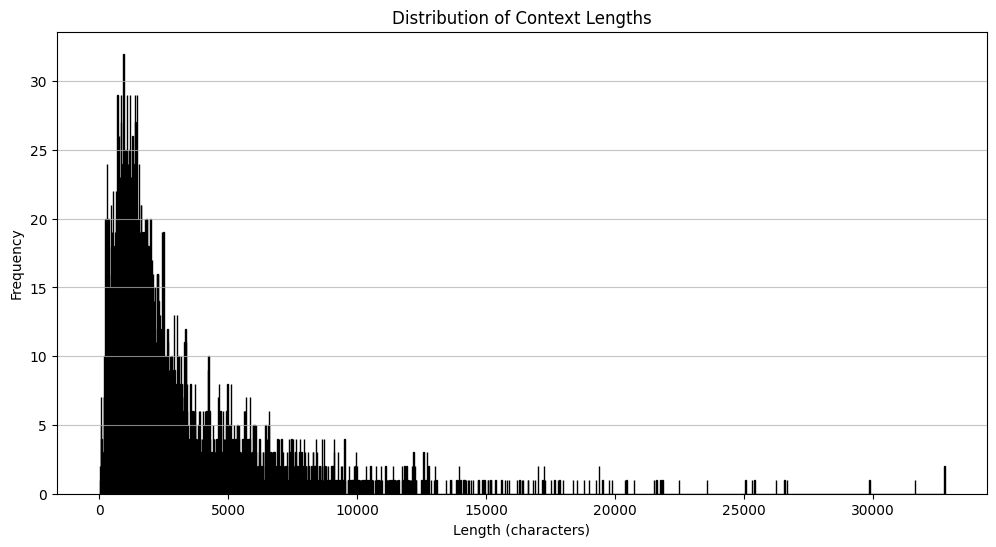

In [38]:
# create a graph that shows the distribution of context lengths
import matplotlib.pyplot as plt


lengths = [len(c.strip()) for c in contexts_cleaned]
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=range(0, max(lengths) + 10, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Calculate the number of tokens 

In [40]:
import json
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
import tiktoken

# === Config ===
DOCS_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"
CHUNK_SIZE = 1500
CHUNK_OVERLAP = 200
EMBEDDING_MODEL = "text-embedding-ada-002"
PRICE_PER_MILLION = 0.10  # USD

# === Load JSON ===
with open(DOCS_PATH) as f:
    data = json.load(f)  # data is now a list of strings

# === Tokenizer ===
enc = tiktoken.encoding_for_model(EMBEDDING_MODEL)

def count_tokens(text):
    return len(enc.encode(text))

# === Prepare Docs ===
docs = []
for idx, context in enumerate(data):
    if isinstance(context, str) and context.strip():
        docs.append(Document(page_content=context, metadata={"row_index": idx}))

# === Chunker ===
text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

# === Process & Count ===
total_tokens = 0
total_chunks = 0

for doc in docs:
    chunks = text_splitter.split_documents([doc])
    total_chunks += len(chunks)

    for chunk in chunks:
        token_count = count_tokens(chunk.page_content)
        total_tokens += token_count

# === Estimate Cost ===
estimated_cost = (total_tokens / 1_000_000) * PRICE_PER_MILLION

print(f"🔹 Total Chunks: {total_chunks}")
print(f"🔹 Total Tokens: {total_tokens:,}")
print(f"💰 Estimated Embedding Cost: ${estimated_cost:.2f}")


Created a chunk of size 1568, which is longer than the specified 1500
Created a chunk of size 1591, which is longer than the specified 1500
Created a chunk of size 1997, which is longer than the specified 1500
Created a chunk of size 1754, which is longer than the specified 1500
Created a chunk of size 4701, which is longer than the specified 1500
Created a chunk of size 3737, which is longer than the specified 1500
Created a chunk of size 7371, which is longer than the specified 1500
Created a chunk of size 1546, which is longer than the specified 1500
Created a chunk of size 4624, which is longer than the specified 1500
Created a chunk of size 1739, which is longer than the specified 1500
Created a chunk of size 1747, which is longer than the specified 1500
Created a chunk of size 2219, which is longer than the specified 1500
Created a chunk of size 2879, which is longer than the specified 1500
Created a chunk of size 4490, which is longer than the specified 1500
Created a chunk of s

🔹 Total Chunks: 9997
🔹 Total Tokens: 3,624,780
💰 Estimated Embedding Cost: $0.36


#### Chunk, Embedd and Save the Context

In [9]:
import os
import json
from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

In [8]:
# Load .env variables
load_dotenv()

# Configuration
DOCS_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"  
CHUNK_SIZE = 1500
CHUNK_OVERLAP = 200

# Load dataset
with open(DOCS_PATH) as f:
    raw_data = json.load(f)

# Create LangChain Documents
docs = [
    Document(page_content=entry.strip(), metadata={"row_index": idx})
    for idx, entry in enumerate(raw_data)
    if isinstance(entry, str) and entry.strip()
]

# Initialize splitter
splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

# Split into chunks
all_chunks = []
for doc in docs:
    row_index = doc.metadata["row_index"]
    chunks = splitter.split_documents([doc])
    for local_idx, chunk in enumerate(chunks):
        chunk_id = f"row_{row_index}_chunk_{local_idx}"
        all_chunks.append({
            "chunk_id": chunk_id,
            "row_index": row_index,
            "text": chunk.page_content
        })

print(f"Total chunks created: {len(all_chunks)}")

Created a chunk of size 1568, which is longer than the specified 1500
Created a chunk of size 1591, which is longer than the specified 1500
Created a chunk of size 1997, which is longer than the specified 1500
Created a chunk of size 1754, which is longer than the specified 1500
Created a chunk of size 4701, which is longer than the specified 1500
Created a chunk of size 3737, which is longer than the specified 1500
Created a chunk of size 7371, which is longer than the specified 1500
Created a chunk of size 1546, which is longer than the specified 1500
Created a chunk of size 4624, which is longer than the specified 1500
Created a chunk of size 1739, which is longer than the specified 1500
Created a chunk of size 1747, which is longer than the specified 1500
Created a chunk of size 2219, which is longer than the specified 1500
Created a chunk of size 2879, which is longer than the specified 1500
Created a chunk of size 4490, which is longer than the specified 1500
Created a chunk of s

Total chunks created: 9997


OpenAI’s embeddings are trained with the same internal tokenizer, so retrieval + generation are often well-aligned

In [10]:
# Initialize embedding provider
embedding_model = OpenAIEmbeddings(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model="text-embedding-ada-002"
)

# Embed and store
embedded_chunks = []
for chunk in all_chunks:
    try:
        embedding = embedding_model.embed_query(chunk["text"])
        chunk["embedding"] = embedding
        embedded_chunks.append(chunk)
    except Exception as e:
        print(f"Failed embedding chunk {chunk['chunk_id']}: {e}")

print(f"Successfully embedded {len(embedded_chunks)} chunks.")


Successfully embedded 9997 chunks.


In [11]:
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json", "w") as f:
    json.dump(embedded_chunks, f)

print("Embeddings saved to /Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json")

Chunks saved to /Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json


## Test Retriever 

### Create a Validation Dataset

In [5]:
import pandas as pd
import json

# Load unique contexts
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json", "r") as f:
    unique_contexts = json.load(f)
print(f"Loaded {len(unique_contexts)} unique contexts")

# Load validation dataframe
df_val = pd.read_json("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/Train_Val_Test/df_val.json")
print(f"Loaded validation set with {len(df_val)} rows")

# Get first 200 contexts
first_200_contexts = set(unique_contexts[:200])  # Using a set for faster matching

# Filter df_val to only include rows with context in the first 200
df_filtered = df_val[df_val['context'].isin(first_200_contexts)]

print(f"Filtered DataFrame has {len(df_filtered)} rows")

Loaded 5823 unique contexts
Loaded validation set with 1720 rows
Filtered DataFrame has 0 rows


In [6]:
print(type(unique_contexts))
print(type(unique_contexts[0]))
print(unique_contexts[0])

<class 'list'>
<class 'str'>
Cboe Global Markets, Inc. and Subsidiaries

Consolidated Statements of Income

Years ended December 31, 2023, 2022, and 2021

(In millions, except per share data)














    

2023

    

2022

    

2021

 

Revenues:











Cash and spot markets


$

1,445.1


$

1,777.6


$

1,660.5


Data and access solutions



539.2



497.0



427.7


Derivatives markets


 

1,789.2


 

1,683.9


 

1,406.6


Total revenues


 

3,773.5


 

3,958.5


 

3,494.8


Cost of revenues:











  Liquidity payments


 

1,385.8


 

1,670.2


 

1,650.7


  Routing and clearing



79.1



83.2



87.8


  Section 31 fees



185.7



329.8



179.6


  Royalty fees and other cost of revenues


 

204.9


 

133.6


 

100.6


Total cost of revenues


 

1,855.5


 

2,216.8


 

2,018.7


Revenues less cost of revenues


 

1,918.0


 

1,741.7


 

1,476.1


Operating expenses:











  Compensation and benefits


 

425.8


 

363.0


 

288.5


  Dep

In [7]:
print(df_val['context'].apply(type).value_counts())
print(df_val['context'].iloc[0])

context
<class 'str'>     1150
<class 'list'>     570
Name: count, dtype: int64
['we maintain and operate the assets based on contractual obligations within the lease arrangements , which set specific guidelines consistent within the railroad industry .', 'as such , we have no control over activities that could materially impact the fair value of the leased assets .', 'we do not hold the power to direct the activities of the vies and , therefore , do not control the ongoing activities that have a significant impact on the economic performance of the vies .', 'additionally , we do not have the obligation to absorb losses of the vies or the right to receive benefits of the vies that could potentially be significant to the we are not considered to be the primary beneficiary and do not consolidate these vies because our actions and decisions do not have the most significant effect on the vie 2019s performance and our fixed-price purchase options are not considered to be potentially signifi

In [8]:
df_val['context'] = df_val['context'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

In [9]:
print(df_val['context'].apply(type).value_counts())

context
<class 'str'>    1720
Name: count, dtype: int64


In [10]:
def normalize(text):
    return ' '.join(text.strip().split())

first_200_normalized = set(normalize(c) for c in unique_contexts[:1000])
df_val['context_normalized'] = df_val['context'].apply(normalize)

df_filtered = df_val[df_val['context_normalized'].isin(first_200_normalized)]
print(f"Filtered DataFrame has {len(df_filtered)} rows")

Filtered DataFrame has 71 rows


### Test the retriever

In [11]:
questions = df_filtered['question'].tolist()

In [30]:
#only print the first question 
print(questions[0] if questions else "No questions found in filtered DataFrame")

2024 total opex: Nordson Corp (NDSN) cost-of-sales + S&A


In [16]:
import neo4j
from neo4j_graphrag.retrievers import VectorCypherRetriever
from neo4j import GraphDatabase
from tqdm import tqdm
import pandas as pd
from dotenv import load_dotenv
import os

In [17]:
# Load environment variables from .env file
load_dotenv()

# Read from env
URI = os.getenv("NEO4J_URI")
USER = os.getenv("NEO4J_USER")
PASSWORD = os.getenv("NEO4J_PASSWORD")

# Connect to Neo4j
driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

#### Retriever 1
Combines vector-based similarity searches with graph traversal techniques. Uses the user query to perform simiarlity search to retreive relevant nodes. Subsequently, it executes a cypher query to traverse the grpah based on these nodes. The retrieved context is both semantically meaningul and contxtually enriched by the underlying graph structure. <br>

Applied to the QA Task the following describes the process: <br>
1. The user query is embedded 
2. Vector similarity search is performed on the chunk nodes 
3. The result is enriched with contextual data with graph traversal 


The final graph schema is: 
(:Chunk)-[:PART_OF]->(:Document)-[:MENTIONS]->(:Entity)

the entities are connected through all types of relationships. 